<center><h1>Introducción a Redes Neuronales Artificiales</h1></center>
<center><h2>Tarea 1 - Perceptrones Multicapa o Redes Feed-Forward</h2></center>


|Integrante|Rol|Correo|
|:-|:-|:-|
|Ricardo Carrasco|201204510-k|<ricardo.carrasco.12@sansano.usm.cl>|
|Rolando Casanueva|201204505-3|<rolando.casanueva.12@sansano.usm.cl>|


## Desarrollo

### Parte 1

**A) Implemente una función que genere n datos etiquetados**

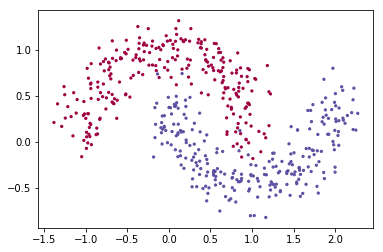

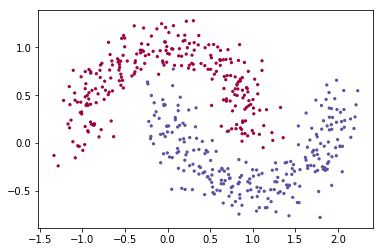

In [26]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
def moons(n):
    X, y = make_moons(n, noise=0.15)
    return X, y
X_b,y_b = moons(500)
X_t, y_t = moons(500)
plt.scatter(X_b[:,0], X_b[:,1], s=5, c=y_b, cmap=plt.cm.Spectral)
plt.show()
plt.scatter(X_t[:,0], X_t[:,1], s=5, c=y_t, cmap=plt.cm.Spectral)
plt.show()

**B) Demuestre con una neurona**

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units=1, input_dim=2, activation = 'hard_sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_b, y_b, epochs=100, batch_size=500)
print (model.evaluate(X_t, y_t, batch_size=500))

Using TensorFlow backend.


ImportError: No module named tensorflow

### Parte 2
**Restricción:** `No usar librerías especializadas, excepto numpy`

In [1]:
import numpy as np
import random as rd
import pandas as pd
from sklearn.preprocessing import StandardScaler


Utilizando la [siguiente referencia](http://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/) implementaremos una red.

**A) Programa de entrenamiento**

Esta sección ha sido subdividida en cuatro etapas, las cuales involucran desde la inicialización de la red hasta la implementación de la rutina principal de entrenamiento. Para este trabajo deberemos primero crear la nueva red, donde cada neurona tiene un conjunto de pesos, durante el entrenamiento tendremos que almacenar propiedades adicionales es por este motivo que definiremos a una **neurona** como un *diccionario* y guardaremos los pesos con el nombre *weights*. Por otra parte, una red se organiza en *capas*, donde la capa de entrada (*input layer*) es una fila del *dataset de entrenamiento*. La verdadera primera capa es la capa escondida (*hidden layer*), la cual es seguida por la capa de salida (*output layer*) que contiene una neurona por cada valor de una clase. Como podemos inferir, organizaremos una capa como un arreglo (*lista*) de neuronas (*diccionarios*) y una red como un arreglo (*lista*) de capas.

```python
neuron = dict()
neuron['weights'] = [value1, value2, value3, ..., valueN]

layer = list()
...
layer = [neuron1, neuron2, neuron3, ..., neuronM]

network = list()
...
network = [layer1, layer2, layer3, ..., layerZ]
```

Para dar valores iniciales a la red de pesos utilizaremos números pequeños aleatoreos (**Libreria random**), los cuales estarán en el rango de 0 a 1.

In [2]:
#--------------------------------------------
#            initialize_network
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   n_inputs:  integer number of inputs
#   n_hidden:  integer number of neurons to 
#              have in the hidden layer
#   n_outputs: integer number of outputs
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    list of list of dictionaries that
#           means an array of layers of neurons
#   FUNCTION_CODING
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = list()
    for i in range(n_hidden):
        hidden_layer.append({'weights': [rd.random() for j in range(n_inputs + 1)]})
    network.append(hidden_layer)
    
    output_layer = list()
    for i in range(n_outputs):
        output_layer.append({'weights': [rd.random() for j in range(n_hidden + 1)]})
    network.append(output_layer)
    
    return network
#   FUNCTION_EXPLANATION
#   Creates a new neural network ready for 
#   training. It accepts three parameters,
#   the number of inputs, the number of neurons
#   to have in the hidden layer and the number 
#   of outputs.
#--------------------------------------------

Podemos notar que la capa escondida contiene *n<sub>hidden</sub>* neuronas y cada neurona tiene *n<sub>inputs</sub> + 1* pesos, una por cada columna en el *dataset* y uno adicional para el **bias** (*sesgo*). También se puede notar que la capa de salida que se conecta a la capa escondida presenta *n<sub>outputs</sub>* neuronas y cada una con *n<sub>hidden</sub> + 1* pesos. Esto permite que cada neurona en la capa de salida esté conectada (*tenga un peso*) con una neurona en la capa escondida.

----------------
#### Forward Propagate

Se puede calcular la salida de una red neuronal mediante la propagación de una señal de entrada a través de las capas hasta que la capa de salida retorne el valor.

Para este proceso tenemos tres partes:
1. Activación de la neurona
2. Transferencia de la neurona
3. Propagación hacia adelante

----------------
El primer paso es calcular la activación de una neurona dadas una entrada. Para este caso, podremos decir que la entrada es una fila del *DataSet* de entrenamiento al igual que en el caso de la capa escondida. La función para calcular es muy cercana a una regresión lineal, donde se calcula la suma de los pesos para cada entrada. El sesgo puede considerarse como aparte, o como que es multiplicado siempre por 1.

\begin{equation*}
activation = ( \sum_{k=1}^n weight_i * input_i ) + bias
\end{equation*}

Gracias a nuestra definición previa podremos siempre definir al *bias* como el último valor del arreglo de pesos, entonces una implementación de esta función es

In [3]:
#--------------------------------------------
#            activate_neuron
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   weights:  list of floats
#   inputs:   list of floats
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    integer value that represent the 
#           activation equation
#   FUNCTION_CODING
def activate_neuron(weights, inputs):
    activation = weights[-1]
    quantum = len(weights) - 1
    for i in range(quantum):
        activation += weights[i] * inputs[i]
        
    return activation
#   FUNCTION_EXPLANATION
#   Calculate the neuron activation for an input
#--------------------------------------------

----------------
Ahora que tenemos nuestra función de activación, veamos como utilizarla. Para poder lograr obtener el resultado deberemos utilizar la función de activación y transferir este valor a través de las capas.

Existen diferentes funciones de transferencia pero tradicionalmente se utiliza la [función Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). Otras opciones pueden ser:

- [Tangente hiperbólica](https://en.wikipedia.org/wiki/Hyperbolic_function)
- [Rectificante](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

La activación de sigmoid, también conocida como función logística, pede tomar cualquier valor y producir un número entre 0 y 1 dentro de su curva, la cual tiene una forma parecida a una S aplastada.
<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="400" height="800" />

Una particularidad de esta función es que se le puede calcular facilmente la derivada, lo cual facilitará implementaciones posteriores. Entonces, definimos la función sigmoid como

\begin{equation*}
S(t) = \frac{1}{1 + e^{-t}}
\end{equation*}

Lo cual implementaremos de la siguiente forma

In [4]:
#--------------------------------------------
#            transfer
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   value: float number
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    float number of transferation
#   FUNCTION_CODING
def transfer(value):
    transfer_value = 1.0 / (1 + np.exp(-value))
    
    return transfer_value
#   FUNCTION_EXPLANATION
#   Calculate the sigmoid function value of input
#--------------------------------------------

----------------
Ya habiendo definido nuestra base, la propagación es una aplicación directa. Trabajando sobre cada capa de la red se calcula la salida de cada neurona, la cual sera utilizada como input para la siguiente capa.

Debido a la estructura que elegimos para la neurona, podremos guardar el valor de salida como una llave del diccionario, además dentro de la iteración de capas deberemos almacenar todos estos valores para que al cambio de capa sean utilizados como los nuevos valores de entrada.

In [5]:
#--------------------------------------------
#            forward_propagate
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network: list of lists
#   row:     list of float values
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    list of float values
#   FUNCTION_CODING
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = list()
        for neuron in layer:
            activation_value = activate_neuron(neuron['weights'], inputs)
            neuron['output'] = transfer(activation_value)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
        
    return inputs
#   FUNCTION_EXPLANATION
#   Propagates the values from a row of values
#   till the output's layer and returns the last
#   list of values
#--------------------------------------------

#### Backward propagate

Esta sección de trabajo es la que permite determinar errores comparando el valor esperado con el valor propagado de la red. Este error es revisado a través de la red desde la capa final hasta la capa escondida asignando responsabilidad sobre el error y actualizando los pesos a medida que avanza.

La propagación del error tiene una base científica en el *Cálculo*, sin embargo como simplificación nos mantendremos al margen de su funcionamiento y nos concentraremos en su uso.

Al igual que la sección anterior, podemos dividir el trabajo en dos partes

1. Derivada de transferencia
2. Error de propagación hacia atras
-----------------
Lo primero es calcular la derivada de transferencia que para este informe estamos utilizando la función **Sigmoid**, cuya derivada se expresa de la siguiente forma

\begin{equation*}
S'(t) = S(t)(1 - S(t))
\end{equation*}

Esto nos permite implementarla de una manera muy sencilla

In [6]:
#--------------------------------------------
#            transfer_derivative
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   S:   float number representing S(t)
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    float number 
#   FUNCTION_CODING
def transfer_derivative(S):
    derivative = S * (1.0 - S)
    
    return derivative
#   FUNCTION_EXPLANATION
#   Calculate the transfer derivative 
#--------------------------------------------

---------------
Ahora que tenemos la función implementada, debemos calcular el error para cada salida de la neurona, esto nos dará la señal de error que propagaremos hacia atrás a través de la red.

Para obtener el error que mencionamos recién es necesario realizar una comparación entre el valor esperado y el valor resultante, a lo cual además multiplicaremos la derivada de la transferencia, esto se expresa matemáticamente como

\begin{equation*}
error = (E(x) - O(x)) * \frac{\partial Sigmoid(x)}{\partial x}
\end{equation*}

Este cálculo de error es usado para neuronas en la capa de salida, donde el valor esperado es el valor de la clase. La señal para una neurona en la capa escondida es calculada como el error de los pesos de cada neurona en la capa de salida.

Ahora bien, la señal del error propagado se acumula y usa para determinar el error de la neurona en la capa escondida de la siguiente forma

\begin{equation*}
Error_{propagado} = (weight_i * error_j) * \partial {transfer} 
\end{equation*}

Podemos observar como el error_j es la señal de la j-ésima neurona en la capa de salida, el weight_k es el peso que conecta la k-ésima neurona con la neurona actual mientras que la derivada de la transferencia se calcula con el valor de salida de la neurona actual.

Como sabemos que nuestra red es un tipo de dato ordenado, por lo que para ir desde la capa final hasta la inicial, basta con recorrerla de manera inversa, es así como debemos calcular el error de la neurona y almacenarlo en la misma, a este error le llamaremos delta para representar el cambio que este involucra. Se podrá apreciar que la señal de error para las neuronas de la capa oculta es un valor acumulativo que proviene desde la capa de salida.

In [7]:
#--------------------------------------------
#            backward_propagate
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network:   list of lists
#   expected:  list of floats
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    boolean of aplication where True
#           means a correctfull run of the algorithm
#   FUNCTION_CODING
def backward_propagate(network, expected):
    try:
        size = len(network)
        iteration = range(size)[::-1]
        for i in iteration:
            layer = network[i]
            errors = list()
            if i != (size - 1):
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in network[i + 1]:
                        error += neuron['weights'][j] * neuron['delta']
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(expected[j] - neuron['output'])
            for k in range(len(layer)):
                neuron = layer[k]
                neuron['delta'] = errors[k] * transfer_derivative(neuron['output'])
        return 0
    except:
        return 1
#   FUNCTION_EXPLANATION
#   Propagates de errors and blame the current neuron
#   by adapting its values
#--------------------------------------------

#### Entrenamiento de la red

La red será entrenada utilizando el metodo SGD *(Stochastic Gradient Descent)*. Esto involucra exponer los datos de entrenamiento multiples veces a la red y que por cada fila de datos propagar las entradas hacia adelante y propagar los errores hacia atras para actualizar los pesos de la red.

Este proceso, al igual como hemos realizado en todo el trabajo, puede descomponerse en dos partes

1. Actualizar Pesos
2. Entrenar la red
---------------------
Dado que ya hemos calculado los errores para cada neurona en nuestra red, podemos utilizar dicho error para actualizar los pesos. Si definimos al peso como **_W_**, un parametro de aprendizaje **_L<sub>r</sub>_**, el error como un delta **$\delta$** y una entrada, causante del error como **_I_**.

\begin{equation*}
W_{new} = W_{prev} + L_r *  \delta * I
\end{equation*}

De la misma forma, se puede actualizar el sesgo con la excepción de que no tiene un parametro de entrada o bien, puede ser evaluado como un parametro de entrada *1.0*.

El paramentro de aprendizaje, referido como *Learning Rate*, controla cuanto cambiar el peso para corregir el error en términos porcentuales. Siempre es preferible utilizar valores de aprendizaje bajos por el impacto que este puede tener.

Una implementación para la actualización de los pesos debe recorrer las neuronas y aplicar la ecuación descrita, cabe resaltar que las entradas utilizadas por capa son referentes a las salidas de la capa anterior.

In [22]:
#--------------------------------------------
#            update_weights
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network:   list of lists
#   row:  list of floats
#   lr:  float number refered to learning rate
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    No outs
#   FUNCTION_CODING
def update_weights(network, row, lr):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += lr * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += lr * neuron['delta']
#   FUNCTION_EXPLANATION
#   Update the values of weights by the Lr and delta given
#--------------------------------------------

--------------------
Una vez que ya tenemos nuestra función de actualización debemos generar el procedimiento para el entrenamiento, el cual se basa en una red inicializada con un *DataSet* entregado, un *learning_rate*, un número de *epoch* (época, o generación) y un número esperado de valores de salida.

In [23]:
#--------------------------------------------
#            train_network
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network:   list of lists
#   train:  dataset for training
#   lr:  float number refered to learning rate
#   n_epoch:  int number for generations of training
#   n_outputs: int number
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    list of errors for different epochs
#   FUNCTION_CODING
def train_network(network, train, lr, n_epoch, n_outputs):
    errors = list()
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1] - 1] = 1
            sum_error += sum([(expected[i] - outputs[i])**2 for i in range(len(expected))])
            backward_propagate(network, expected)
            update_weights(network, row, lr)
        errors.append(sum_error)
    return errors
#   FUNCTION_EXPLANATION
#   Uses all the functions describe above and calculates the
#   error for the epoch
#--------------------------------------------

**B) Programa de predicción**

Un programa que logre realizar una predicción suena algo descabellado, sin embargo, ya teniendo una red neuronal entrenada, podemos realizar una implementación sencilla para generar una solución. Como tenemos la función *forward_propagate*, podemos utilizar los valores de salida que nos genera como una predicción.

En matemática existe una definición en particular que utilizaremos, el **arg max**, siendo los puntos del dominio de una funcion donde los valores son máximos. [Leer más detalles](https://en.wikipedia.org/wiki/Arg_max) Esto es para retornar el valor de salida en la posición de mayor probabilidad.

In [24]:
#--------------------------------------------
#            predict
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network:   list of lists
#   row:  list of floats
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    value of output for maximun arg
#   FUNCTION_CODING
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))
#   FUNCTION_EXPLANATION
#   Predict using the information of a row
#--------------------------------------------

Ahora que tenemos una función para realizar predicciones en base a *forward_propagate* debemos vectorizarla y admitirle un conjunto de ejemplos mayor. Como sabemos que la función aplica sobre una fila de valores, un conjuntos de varios ejemplos estará definido como un dataset de varias filas

In [25]:
#--------------------------------------------
#            multi_predict
#--------------------------------------------
#   FUNCTION_IN_PARAMETERS_DEFINITION
#   network:   list of lists
#   examples:  list of lists
#
#   FUNCTION_OUT_PARAMETERS_DEFINITION
#   out:    list of values of output for maximun arg
#   FUNCTION_CODING
def multi_predict(network, examples):
    predictions = list()
    for row in examples:
        prediction = predict(network, row)
        predictions.append((row[-1], prediction))
    return predictions
#   FUNCTION_EXPLANATION
#   Uses the row prediction and iterates on an
#   example dataset
#--------------------------------------------

**C) Comprobación de datos**

Para demostrar el funcionamiento del algoritmo utilizaremos utilizaremos un dataset de clasificación de semillas el cual podemos encontrar en [la siguiente url](http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt). Los datos se normalizan según lo entregado en el enunciado de la tarea.

In [12]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pd.read_csv(url, sep=r'\s+', header=None)
X_train = df.ix[:,0:6]
y_train = df.ix[:,7]
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

Ahora que tenemos normalizados los datos, debemos convertirlos a un formato legible por nuestra implementación, la cual debe tener los valores de las etiquetas **y_train** como final de las filas del dataset.

In [16]:
DataSeeds = X_train.tolist()
for idx, row in enumerate(DataSeeds):
    row.append(y_train[idx])


Ahora tomamos los datos, inicializamos la red y generamos nuestra solución

In [21]:
n_inputs = 7
n_outputs = 3
n_hidden = 5 # Alterable

rd.seed(1)
network = initialize_network(n_inputs, n_hidden, n_outputs)

n_epochs = 400
learning_rate = 0.5

errors = train_network(network, DataSeeds, learning_rate, n_epochs, n_outputs)